# Introduction to neural networks

A _neural network_ is a network of interconnected _artificial neurons_. The performance of a neural network is determined in equal parts by the type of processing occurring within each neuron and the network structure.

In this code, we will be using two important Python packages, `numpy` for numerical computations and linear algebra, and `matplotlib` for fast visualization.


In [110]:
import numpy as np  # Fast math and arrays
import matplotlib.pyplot as plt  # Displays

## A simple McCulloch-Pitts neuron

In the simplest McCulloch-Pitts model, a neuron is charactrized by an _activation function_ $f(x)$, which calculates the response of a neuron $i$ in terms of its summed inputs and an internal threshold.

$$
y_i = f(\sum_j x_j - \theta)
$$

In the simplest model, we will assume that the neuron's activation function is a _step function_, which return $1$ when $\sum_j x_j \ge \theta$, and $0$ otherwise. 

$$
y_i = \begin{cases} 1 ~ \mathrm{if}~f(\sum_j x_j - \theta) \ge 0 \\
0 ~\mathrm{if} ~ f(\sum_j x_j - \theta) < 0 
\end{cases}
$$


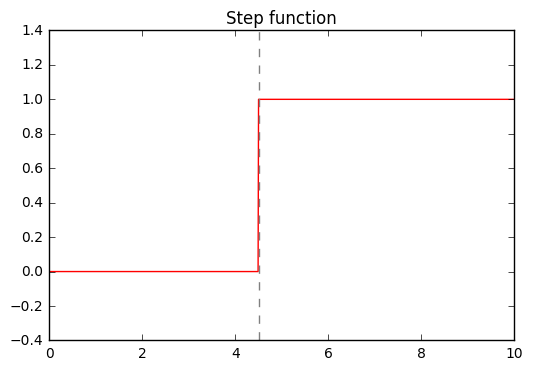

In [111]:
# Step function with theta = 2.5
theta = 4.5
x = np.arange(0, 1000)/100.0
y = [0 if j < theta else 1 for j in x]
ymin, ymax = (-0.4, 1.4)
plt.axis([0, 10, ymin, ymax])
plt.plot(x, y, 'red')
plt.title("Step function")
plt.plot([theta, theta], [ymin, ymax], "--", color="grey")
plt.show()

## The Bird Brain network

Now, with this system in place, we can create our simplest network ever: A tiny __bird brain__ that either eats, or doesn't eat, the input object depending on its fatures.

Our bird hastwo input neurons:

1. A `neuron_circle` neuron encoding whether the object we are looking at is a circle,
2. A `neural_small` neuron encoding whether the object we are looking at is small

The goal is to modify the neuron's threshold to respond only to objects that are both small and round.  


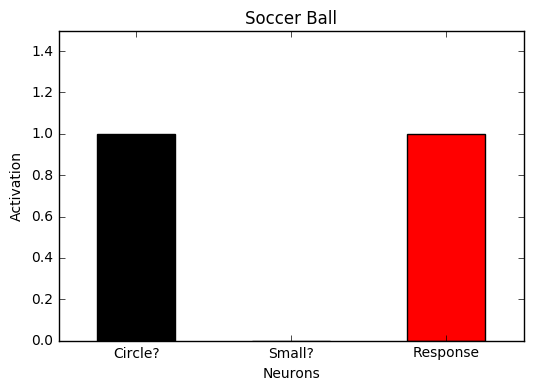

In [112]:
# Input neurons
neuron_circle = 0
neuron_small = 0

# Internal threshold
theta = 0

# Plot title (ignore!)
title = ""

# A few sample stimuli
berry = {"name" : "Berry", "value" : [1, 1]}
cat = {"name" : "Cat", "value" : [0, 0]}
rock = {"name" : "Rock", "value" : [0, 1]}
soccerball = {"name" : "Soccer Ball", "value" : [1, 0]}

def step( x ):
    """Step function"""
    if x >= theta:
        return 1
    else:
        return 0
        
def response():
    """Response of detector neuron"""
    return step( neuron_circle + neuron_small )

def apply_stimulus(stim):
    """Applies one of the stimuli"""
    global neuron_circle
    global neuron_small
    global title
    neuron_circle = stim["value"][0]
    neuron_small = stim["value"][1]    
    title = stim["name"]

apply_stimulus(soccerball)

# Plot the results
fig, ax = plt.subplots()
ax.axis([-0.5, 2.5, 0, 1.5])
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["Circle?", "Small?", "Response"])
ax.set_ylabel("Activation")
ax.set_xlabel("Neurons")
ax.bar(np.arange(2) - 0.25, [neuron_circle, neuron_small], 0.5, color='black')
ax.bar(1.75, response(), 0.5, color='red')
ax.set_title(title)

plt.show()

## Manipulating synapses: Gradient descent

Neural networks use _synaptic weights_ to scale the effects of their inputs. Thus, the full activation function looks like this 

$$
y_i = f(\sum_j w_{j,i}x_j - \theta)
$$

As an example, we will learn how to create neurons that recognize simple numbers

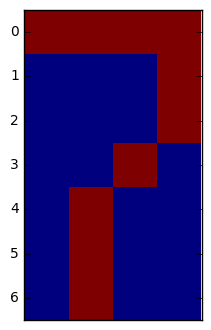

In [113]:
num = np.loadtxt("7.txt")  # Load the corresponding file , 1...9.txt
plt.imshow(num, interpolation="None")
plt.xticks([])
plt.show()


We will start with a single neuron that recognizes the number 7. The neuron uses a linar activation function. Its input values are stored in 28-element vector called `x`. The synapses are stored in a randomly initialized vector `w` 

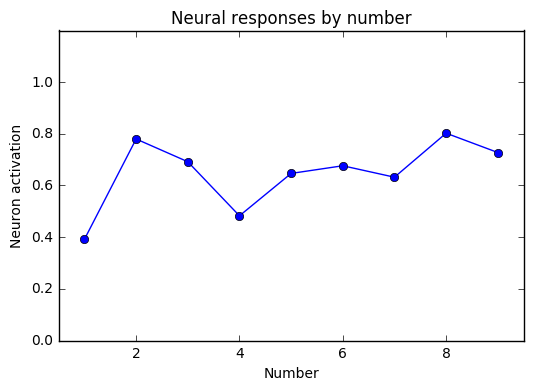

In [114]:
x = np.zeros((num.size))            # Input values
w = np.random.random(num.size) / 10   # Synapses
eta = 0.01  # Learning rate

def set_inputs(digit):
    """Loads the inputs corresponding to a digit into the input values"""
    global x
    if digit >= 1 and digit < 10:
        x = np.loadtxt("%s.txt" % digit).flatten()
        
def activation():
    """Linear activation rule"""
    inputs = w * x
    return sum(inputs)

def calculate_response(digit):
    """Calculates the response of the neuron to a digit"""
    set_inputs(digit)
    return activation()

vals = np.arange(1, 10)
ys = [calculate_response(j) for j in vals]
plt.axis([0.5, 9.5, 0, 1.2])
plt.plot(vals, ys, "bo-")
plt.title("Neural responses by number")
plt.xlabel("Number")
plt.ylabel("Neuron activation")
plt.show()

Now, we implement gradient descent. For each input value $ i \in 1..9$, the error function is defined as follows:

$$
E_i = \begin{cases} \frac{1}{2} (1 - y_i)^2 ~ \mathrm{if} ~ i = 7 \\
\frac{1}{2} (0 - y_i)^2 ~\mathrm{if} ~ i \ne 7 
\end{cases}
$$

Gradient descent is performed by calculating the following derivative:

$$
\frac{\partial E}{\partial w_j} = \frac{\partial E}{\partial y} \times \frac{\partial y}{\partial w_j} 
$$

which is the product of two separate terms, which can be calculated separately. The first term can be simplified this way:

$$
\begin{aligned}
\frac{\partial E}{\partial y} &= \frac{\partial \frac{1}{2} [t(p) - y]^2}{\partial y} \\
&= -[t(p) - y]
\end{aligned}
$$

The second term, on the other hand, simply reduces to the corresponding input $x_j$

$$
\begin{aligned}
\frac{\partial y}{\partial w_j} &= \frac{\partial \sum_j w_j x_j}{\partial w_j} \\
&= x_j
\end{aligned}
$$

And therefore:
$$
\frac{\partial E}{\partial w_j} = -[t(p) - y] \times x_j
$$

In [115]:
target_num = 7  # Targer number

def target(i):
    """Desired response function, t(p)"""
    if i == target_num:
        return 1.0
    else:
        return 0.0

def error(i, response):
    """Calculates the error function"""
    return 0.5 * ((target(i) - response) ** 2)
    
def gradient_descent(n = 1):
    """Performs the gradient descent algorithm over N epochs"""
    global w
    for i in np.arange(n):
        dw = np.zeros((num.shape)).flatten()  # General dW = 0.
        e = 0.0 
        for j in vals:  # For every number in our set
            y = calculate_response(j)
            e += error(j, y)  # Calculate the error
            dwj = x * (target(j) - y)
            dwj = dwj / len(vals)   # Increments dW with this number's results
            dw += dwj 
        
        E.append(e)
        w += eta * dw  # updates W



Now, let's pick a target number to learn, `target_num`, and learn:

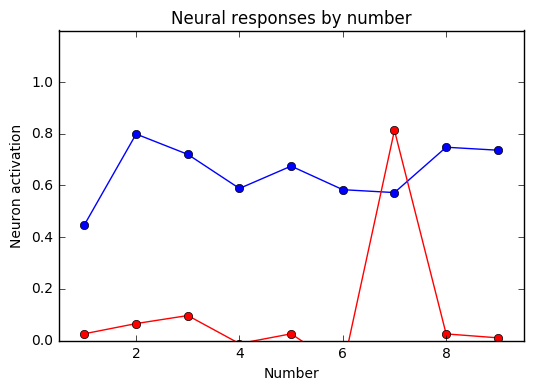

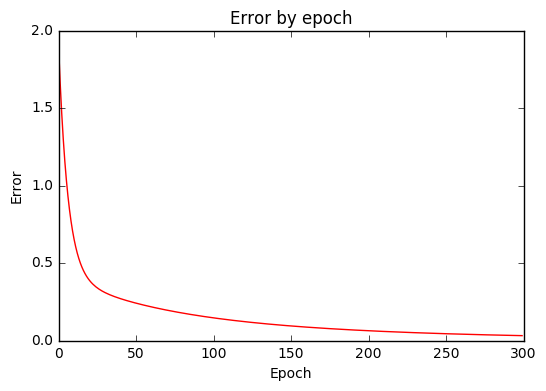

In [116]:
target_num = 7
E = []  # Error by epoch

w = np.random.random(num.size)/10   # Synapses

ys_start = [calculate_response(j) for j in vals]

plt.axis([0.5, 9.5, 0, 1.2])
plt.plot(vals, ys_start, "bo-")

gradient_descent(n = 300)

ys_end = [calculate_response(j) for j in vals]
plt.plot(vals, ys_end, "ro-")
plt.title("Neural responses by number")
plt.xlabel("Number")
plt.ylabel("Neuron activation")
plt.show()

plt.plot(E, "r-")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Error by epoch")
plt.show()

## Examining the synaptic weights

To understand neural networks, it is common to examine the synaptic weights. This will be fundamental as networks get more complicated. 


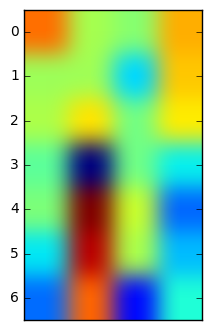

Response: 0.813672000741


In [117]:
res = np.reshape(w, (7,4))
plt.imshow(res, interpolation='kaiser')
#plt.title("Synaptic weights when target number is %s" % target_num)
plt.xticks([])
set_inputs(1)
plt.show()
r = calculate_response(target_num)
print("Response: %s" % r)

## Problems with perceptrons

Let's try to create a network that can perform a XOR logical operation (XOR gate). The network has two input units, $x_1$ and $x_2$, both of which can take the values 0 and 1. The response of the output neuron $y$ should be $y = 1$ when its inputs are $(1, 0)$ or $(0, 1)$, and $y = 0$ when its inputs are $(1, 1)$ or $(0, 0)$

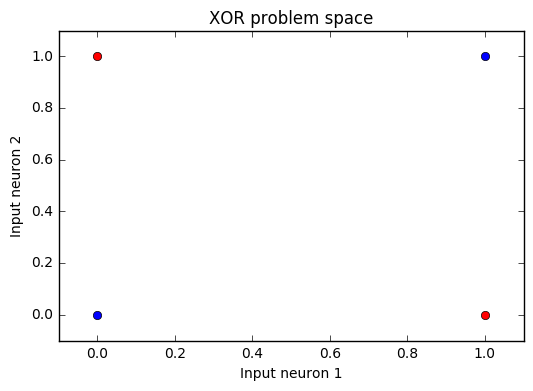

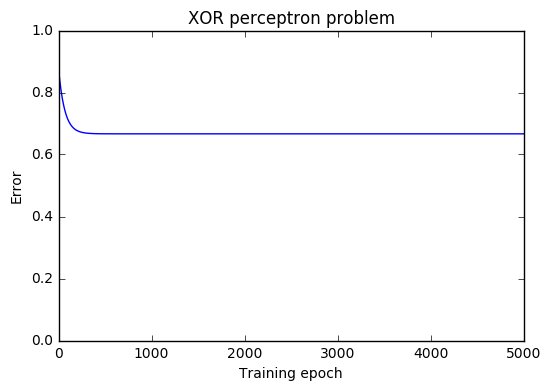

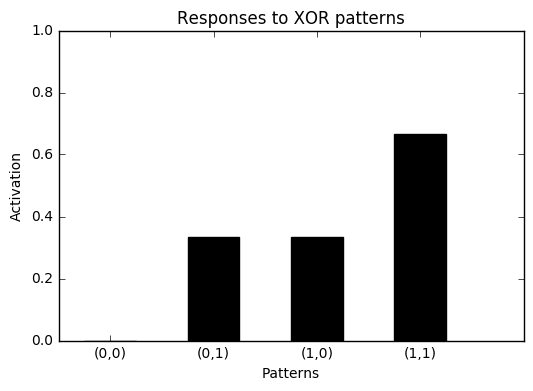

In [118]:
x = np.zeros((2))            # Input values
w = np.random.random((2)) / 10   # Synapses
eta = 0.01  # Learning rate

E = []

patterns = [[0, 0], [0, 1], [1, 0], [1, 1]]

def set_inputs(vals):
    """Loads the inputs corresponding to a digit into the input values"""
    global x
    x = np.array(vals)
    
def activation():
    """Linear activation rule"""
    inputs = w * x
    return sum(inputs)

def target(val):
    """Desired response function, t(p)"""
    if  np.all(val == np.array([0, 1])) or np.all(val == np.array([1, 0])):
        return 1.0
    else:
        return 0.0
    
def gradient_descent(n = 1):
    """Performs the gradient descent algorithm over N epochs"""
    global w
    for i in np.arange(n):
        dw = np.zeros((2))  # General dW = 0.
        e = 0.0 
        for j in patterns:  # For every number in our set
            y = calculate_response(j)
            e += error(j, y)  # Calculate the error
            dwj = x * (target(j) - y)
            dwj = dwj / len(patterns)   # Increments dW with this number's results
            dw += dwj 
        
        E.append(e)
        w += eta * dw  # updates W

# Plot the problem space

plt.plot([0, 1], [1, 0], 'ro')
plt.plot([0, 1], [0, 1], 'bo')
plt.axis([-0.1, 1.1, -0.1, 1.1])
plt.xlabel("Input neuron 1")
plt.ylabel("Input neuron 2")
plt.title("XOR problem space")

plt.show()
        
# Results of training

n_epochs = 5000        
gradient_descent(n_epochs)
plt.axis([0, n_epochs, 0, 1])
plt.xlabel("Training epoch")
plt.ylabel("Error")
plt.title("XOR perceptron problem")
plt.plot(E)
plt.show()

# Plot the responses after training

# Plot the responses to the XOR patterns
y_end = [calculate_response(p) for p in patterns]
fig, ax = plt.subplots()
ax.axis([-0.5, 3.5, 0, 1])
ax.set_xticks(np.arange(5))
ax.set_xticklabels(["(%s,%s)" % tuple(p) for p in patterns])
ax.set_ylabel("Activation")
ax.set_xlabel("Patterns")
ax.bar(np.arange(4) - 0.25, y_end, 0.5, color='black')
ax.set_title("Responses to XOR patterns")
plt.show()

## Feedforward neural networks

To alleviate the problems of perceptrons, we need to complicate our networks in two ways:

1. First, introducing non-linear activation functions
2. Second, adding a new layer (the _hidden_ layer) between input and output

The most common non-linear activation functions are the _sigmoid_ function and the hyperbolic tangent (_tanh_) function.

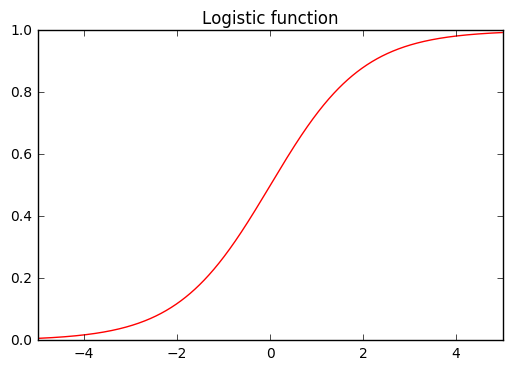

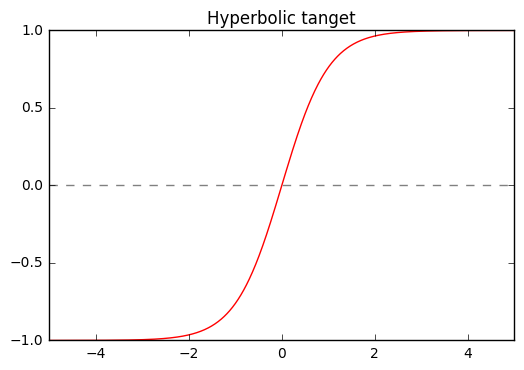

In [119]:
x = np.arange(-500, 500)/100.0

def logistic(x, gain = 1.0):
    """Sigmoid logistic function"""
    return 1 / (1 + np.exp(-x * gain))

def hypertan(x, gain = 1.0):
    """Hyperbolic tangent"""
    return np.tanh(x * gain)

y1 = [logistic(j) for j in x]
ymin, ymax = (0, 1)
plt.axis([-5, 5, ymin, ymax])
plt.plot(x, y1, 'red')
plt.title("Logistic function")
plt.show()

y2 = [hypertan(j) for j in x]
ymin, ymax = (-1, 1)
plt.axis([-5, 5, ymin, ymax])
plt.plot(x, y2, 'red')
plt.plot([-5, 5], [0, 0], "--", color="grey")
plt.title("Hyperbolic tanget")
plt.show()

## Backpropagation

Backpropagatio is a generalization of the gradient descent algorithm. 

To calculate the gradient, we apply the chain rule twice:

$$
\frac{\partial E}{\partial w_{i,j}} = \frac{\partial E}{\partial y_j}  \frac{\partial y_j}{\partial \textrm{in}_j}  \frac{\partial \textrm{in}_j}{\partial w_{i,j}}
$$

where $in_j$ is the net (summed) input to neuron $j$, and $y_j$ is its output: $y_j = f(\textrm{in}_j)$

Now, we can consider these three factors separately.  

The second factor is the derivative of the activation function

$$
\begin{aligned}
\frac{\partial y_j}{\partial \textrm{in}_j} &= \frac{\partial f(\textrm{in}_j)}{\partial \textrm{in}_j} \\
&= f'(\textrm{in}_j) 
\end{aligned}
$$

And the third factor the output of the pre-synaptic neuron:

$$
\begin{aligned}
\frac{\partial \textrm{in}_j}{\partial w_{i,j}} &= \frac{\partial \sum_k w_{k,j}y_k}{\partial w_{i,j}} \\
&= y_i
\end{aligned}
$$

Now, the first factor is the error with respect to the output. In the case of the output layer, this can be calculated directly. But how about the middle layer(s)?

The intuition is that $\frac{\partial E}{\partial y_j}$ can be calculated recursively. If we know the error of the layer below, we know how the error is affected by changes of $y_j$! in fact, that can be calculated as...

$$
\frac{\partial E}{\partial y_j} = \sum_k (\frac{\partial E}{\partial o_k} \frac{\partial o_k}{\partial \textrm{in}_k} w_{j,k})
$$

Because we can measure exactly the error of the bottom (output) layer, we can recurively calculate the error in the upper layer by multiplying it by the synpatic layer in between.

And that, of course, how backpropagation got its name: We are propagating back the error through the synaptic matrices!  

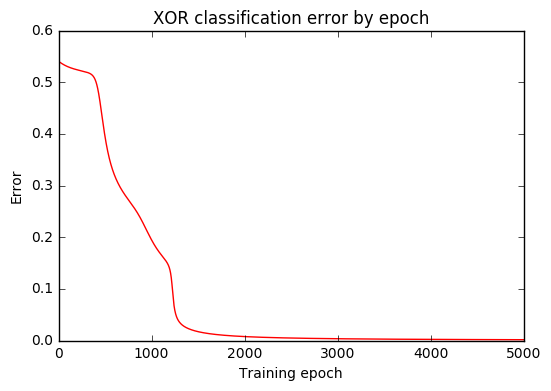

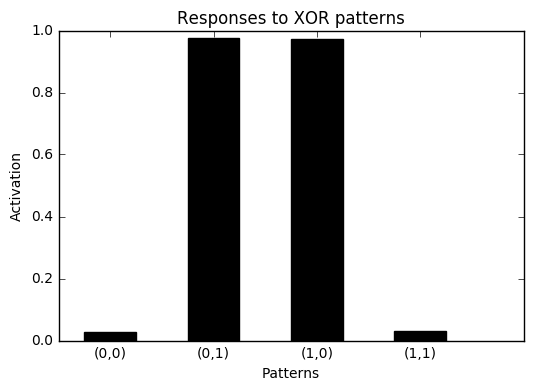

In [120]:
# A Feedforward neural network solving the XOR problem with backprop.

n_input  = 2
n_hidden = 5
n_output = 1

x  = np.zeros((1, n_input))                              # Input values
w1 = (np.random.random((n_input, n_hidden)) / 5) - 0.1    # First layer of synapses
h  = np.zeros((1, n_hidden))                              # Hidden layer
w2 = (np.random.random((n_hidden, n_output)) / 5) - 0.1   # Second layer of synapses

eta = 1.0   # Learning rate. This is higher than usual.

# The patterns to learn

patterns = [[0, 0], [0, 1], [1, 0], [1, 1]]

# Redefining some crucial functions

def logistic(x, deriv = False):
    """Sigmoid logistic function (with derivative)"""
    if deriv:
        return x * (1 - x)
    else:
        return 1 / (1 + np.exp(-x))

    
def set_inputs(vals):
    """Sets a given XOR pattern into the input value"""
    global x
    x = np.array(vals).reshape((1,2))
    
    
def activation():
    """Spreads activation through a network"""
    global h
    
    # First pass, from input to hidden layer
    h_input = np.dot(x, w1)
    h = logistic(h_input)
    
    # Second pass, from input layer to output
    output_input = np.dot(h, w2)
    return logistic(output_input)


def target(val):
    """Desired response function, t(p)"""
    if  np.all(val == np.array([0, 1])) or np.all(val == np.array([1, 0])):
        return 1.0
    else:
        return 0.0

    
def backprop(n = 1):
    """Performs the backpropagation algorithm over N epochs, returns error function"""
    E = []
    global w1
    global w2
    for i in np.arange(n):
        e = 0.0

        for p in patterns:
            o = calculate_response(p)
            e += error(p, o)
            
            # Error in output layer
            o_error = target(p) - o
            do = o_error * logistic(o, deriv = True)
            
            # error in hidden layer
            h_error = np.dot(do, w2.T) 
            dh = h_error * logistic(h, deriv = True)
            
            dw2 = np.dot(h.T, do) 
            dw1 = np.dot(x.T, dh)
            
            w2 += eta * dw2
            w1 += eta * dw1
        
        E.append(np.asscalar(e))  # Error at epoch i 
    return E  # Returns the list of error by epoch
            

# Plot the error function by epoch
plt.plot(backprop(5000), "r-")
plt.xlabel("Training epoch")
plt.ylabel("Error")
plt.title("XOR classification error by epoch")
plt.show()

# Plot the responses to the XOR patterns
y_end = [calculate_response(p) for p in patterns]
fig, ax = plt.subplots()
ax.axis([-0.5, 3.5, 0, 1])
ax.set_xticks(np.arange(5))
ax.set_xticklabels(["(%s,%s)" % tuple(p) for p in patterns])
ax.set_ylabel("Activation")
ax.set_xlabel("Patterns")
ax.bar(np.arange(4) - 0.25, y_end, 0.5, color='black')
ax.set_title("Responses to XOR patterns")
plt.show()